# GAN

Este projeto utiliza uma GAN (_Generative Adversarial Network_) para melhorar a resolução de imagens e retirar textos da mesma. A rede **Generativa** (_Generator Network_) tenta produzir imagens cada vez melhores (com melhor resolução e sem texto) para "enganar" a rede **Crítica** (_Descriminator Network_ ou _Critic Network_).

A primeira parte do código recebe como entrada imagens de alta resolução e insere caracteres aleatórios na imagem.

### _Imports_ iniciais

In [1]:
from PIL import Image, ImageDraw, ImageFont
from fastai.vision.gan import *
from fastai.callbacks import *
from fastai.vision import *

import fastai

### Criação dos caminhos de arquivos

In [2]:
path = untar_data(URLs.PETS, dest='/home/jupyter/playground/pets-gan/data')

In [3]:
path_high_res = path/'images'
path_low_res = path/'crappy'

### Função para "piorar" imagens

A função `crappify()` tira a qualidade das imagens e adiciona um texto aleatório na imagem.

In [4]:
# Função que piora as imagens de entrada e adiciona texto aleatório
def crappify(filename, item):
    destination = path_low_res/filename.relative_to(path_high_res)
    destination.parent.mkdir(parents=True, exist_ok=True)
    image = PIL.Image.open(filename)
    target_size = resize_to(image, 96, use_min=True)
    image = image.resize(target_size, resample=PIL.Image.BILINEAR).convert('RGB')
    width, height = image.size
    quality = random.randint(10, 70)
    ImageDraw.Draw(image).text((random.randint(0, width//2), random.randint(0, height//2)), str(quality), fill=(255, 255, 255))
    image.save(destination, quality=quality)

O código abaixo pega a base de imagens em alta resolução e as transforma, piorando-as.

In [5]:
# Executa o código acima no dataset escolhido
image_list = ImageList.from_folder(path_high_res)
parallel(crappify, image_list.items)

### Definição dos parâmetros da Rede

Define parâmetros iniciais da rede neural, como tamanho do **batch** (`batch size`), valor do **weight decay** e arquitetura do modelo pré-treinado (`resnet18`)

In [6]:
# Tamanho do batch
bs = 16

# Tamanho das imagens
size = 128

# Weight Decay
wd = 1e-3

# Limites para rede UNET
y_range = (-3.,3.)

# Arquitetura do modelo para transfer learning
arch = models.resnet18

## Rede Generator

Abaixo é criada a rede *Generator* da GAN, lendo os dados com baixa resolução e treinando a rede.

In [7]:
# Realiza a leitura dos dados da pasta de imagens de baixa resolução
data_gen = ImageImageList \
    .from_folder(path_low_res) \
    .split_by_rand_pct(0.1, seed=42) \
    .label_from_func(lambda x: path_high_res/x.name) \
    .transform(
        get_transforms(max_zoom=2.), 
        size=size, 
        tfm_y=True
    ) \
    .databunch(bs=bs) \
    .normalize(
        imagenet_stats,
        do_y=True
    )

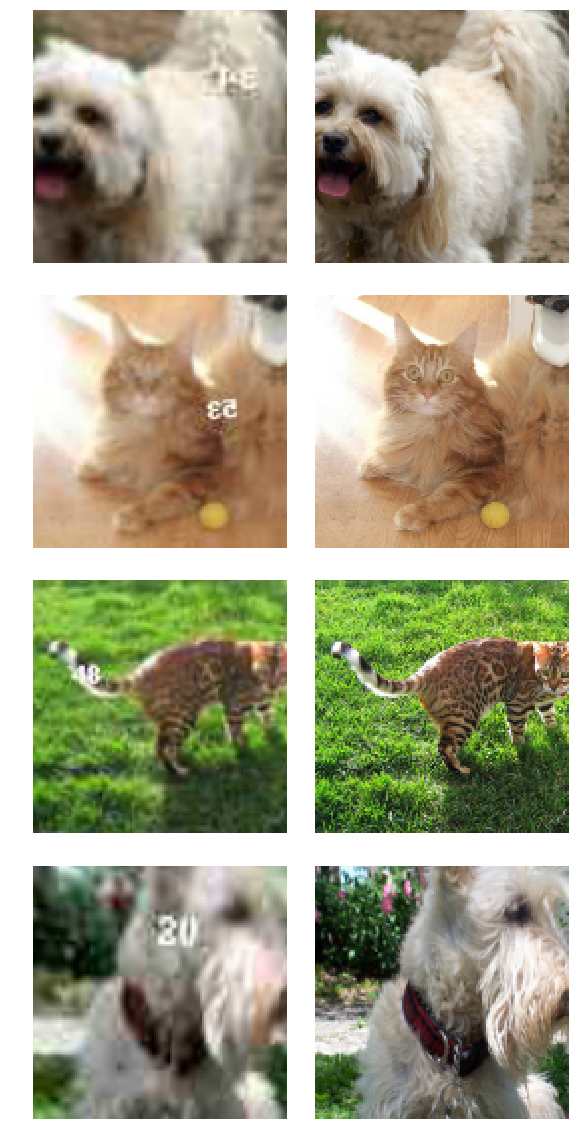

In [8]:
# Mostra um batch de imagens
data_gen.show_batch(4)

A UNET foi desenvolvida por Olaf Ronneberger para Segmentação de imagem biomédicas. A arquitetura contém dois caminhos. O primeiro caminho é o caminho de contração (também chamado de _encoder_) que é usado para capturar o contexto na imagem. O codificador é apenas uma pilha tradicional de camadas convolutionais e _max pooling_. O segundo caminho é o caminho de expansão simétrico (também chamado de _decoder_) que é usado para permitir uma localização precisa usando convoluções transpostas.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [9]:
# Cria a arquitetura do UNET Learner
learn_gen = unet_learner(
    data_gen, 
    models.resnet18, 
    wd=wd, 
    blur=True, 
    norm_type=NormType.Weight,
    self_attention=True, 
    y_range=y_range, 
    loss_func=MSELossFlat()
)

O `Learner` acima utiliza o Erro Quadrático Médio (**Mean Square Error** - `MSELossFlat()`) entre o pixel real e o pixel da predição:
![MSE](https://wikimedia.org/api/rest_v1/media/math/render/svg/e258221518869aa1c6561bb75b99476c4734108e)

In [10]:
# Realiza o treinamento da rede com a política de 1cycle com duas épocas
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.056673,0.051923,01:48
1,0.049890,0.044620,01:42


In [11]:
# "Descongela" as camadas da rede ResNet
learn_gen.unfreeze()

In [12]:
# Faz o treinamento do modelo, mas agora atualizando os pesos da ResNet também
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))   

epoch,train_loss,valid_loss,time
0,0.049464,0.043586,01:50
1,0.048401,0.041535,01:50
2,0.044698,0.040610,01:51


In [13]:
# Grava o modelo
learn_gen.save('gen-pre2')

### Salva as imagens geradas

O loop abaixo faz a predição de todo o conjunto de imagens, chamando a rede generativa para predizer o conjunto de imagens.

In [14]:
# Carrega o modelo
learn_gen.load('gen-pre2');

In [15]:
# Inicializa o caminho das imagens geradas
path_gen = path/'image_gen'

# Cria a pasta
path_gen.mkdir(exist_ok=True)

# Carrega o dataloader 
dataloader = data_gen.fix_dl

# Carrega os itens dentro do dataloader
names = dataloader.dataset.items
i = 0

for batch in dataloader:
    predictions = learn_gen.pred_batch(batch=batch, reconstruct=True)
    
    for prediction in predictions:
        prediction.save(path_gen/names[i].name)
        i += 1

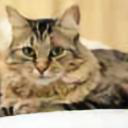

In [16]:
# Mostra uma imagem de teste
PIL.Image.open(path_gen.ls()[0])

## Rede Critic

Agora, com a **Generator** treinada, passamos à segunda parte de rede GAN, a rede **Critic** (ou **Descriminator**) que fará a descriminação da qualidade da rede **Generator**.

In [17]:
# Faz a limpeza da memória 
learn_gen=None
gc.collect()

20

Cria o objeto de dados contendo as imagens geradas (baixa resolução) e as imagens originais (alta resolução).

In [18]:
# Pasta de imagens geradas e pasta de imagens originais
classes = ['image_gen', 'images']

# Cria o objeto de dados contendo as imagens geradas e as imagens originais
data_crit = ImageList.from_folder(path, include=classes) \
    .split_by_rand_pct(0.1, seed=42) \
    .label_from_folder(classes=classes) \
    .transform(
        get_transforms(max_zoom=2.), 
        size=size
    ) \
    .databunch(bs=bs) \
    .normalize(imagenet_stats)

Mostra um __batch__ de exemplos.

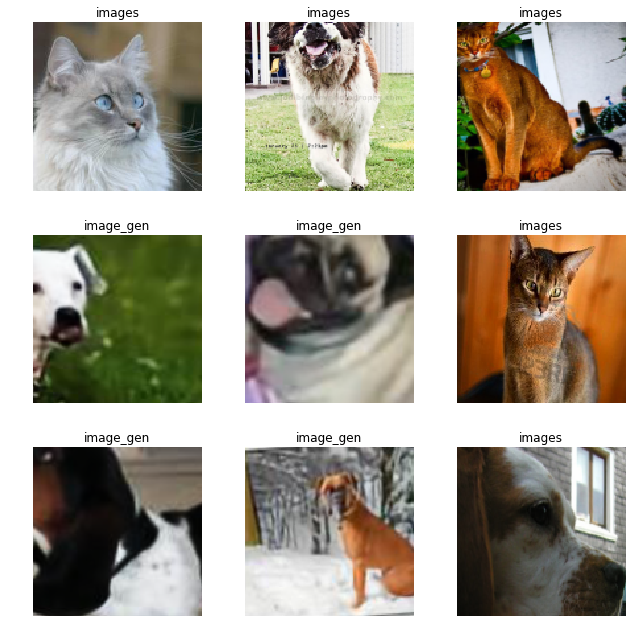

In [19]:
# Mostra exemplos
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

Cria o objeto `Learner` passando o objeto de dados e chama a função `gan_critic()` do Fast.ai, que retorna a arquitetura da GAN necessária para execução do código de treinamento e validação.

In [20]:
# Cria o Learner da rede Descriminadora
learn_critic = Learner(
    data_crit, 
    gan_critic(), 
    metrics=accuracy_thresh_expand, 
    loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), 
    wd=wd
)

In [21]:
# Treina a rede Descrminadora com a política de 1cycle
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.692483,0.694622,0.512108,04:33
1,0.381010,0.788939,0.633077,04:35
2,0.097701,0.557855,0.771595,04:36
3,0.081522,0.034325,0.989801,04:35
4,0.048732,0.037719,0.989487,04:35
5,0.031468,0.032315,0.990826,04:35


In [22]:
# Salva o modelo
learn_critic.save('critic-pre2')

## GAN

Agora, com as redes **generativa** e **descriminadora** treinadas, cria-se a rede adversarial GAN.

In [23]:
# Limpa a memória
learn_crit=None
learn_critic=None
learn_gen=None
gc.collect()

15824

In [45]:
gc.collect()

0

Leitura das imagens alteradas (menor resolução e com texto) e imagens originais (alta resolução).

In [24]:
# Pasta das imagens "pioradas" e a pasta de imagens originais
classes = ['crappy', 'images']

# Cria o objeto de dados contendo as imagens "pioradas" e as imagens originais
data_crit = ImageList.from_folder(path, include=classes) \
    .split_by_rand_pct(0.1, seed=42) \
    .label_from_folder(classes=classes) \
    .transform(
        get_transforms(max_zoom=2.), 
        size=size
    ) \
    .databunch(bs=bs) \
    .normalize(imagenet_stats)

Recriação do `Learner` da rede crítica, carregando o modelo previamente treinado com `load('critic-pre2')`

In [25]:
# Cria o Learner da rede crítica com o modelo treinado previamente
learn_crit = Learner(
    data_crit, 
    gan_critic(), 
    metrics=None, 
    loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), 
    wd=wd
).load('critic-pre2')

Recriação do `Learner` da rede generativa, carregando o modelo previamente treinado com `load('gen-pre2')`

In [26]:
# Cria a rede generativa com o modelo treinado previamente
learn_gen = unet_learner(
    data_gen, 
    arch, 
    wd=wd, 
    blur=True, 
    norm_type=NormType.Weight,
    self_attention=True, 
    y_range=y_range, 
    loss_func=MSELossFlat()
).load('gen-pre2')

Para definir um `Learner` do GAN, é necessário especificar os objetos para a rede generativa e para a rede crítica. O _switcher_ é um _callback_ que decide quando mudar do discriminador para o gerador e vice-versa. Aqui fazemos tantas iterações do discriminador quantas forem necessárias até que a perda seja < 0,5, em seguida, uma iteração do gerador.

A perda da rede crítica é dada por `learn_crit.loss_func`. É usada a média dessa função de perda no _batch_ de previsões reais e o _batch_ de predições falsas.

A perda da rede generativa é a soma ponderada (pesos em `weights_gen`) de `learn_crit.loss_func` no _batch_ de imagens falsas (passados pela rede crítica para se tornarem predições) com um alvo de 1, e o `learn_gen.loss_func` aplicado à saída (_batch_ de falsos) e o alvo (_batch_ correspondente de imagens de alta resolução).

In [27]:
# Inicializa o switcher para a troca entre a rede generativa e a rede crítica
switcher = partial(
    AdaptiveGANSwitcher, 
    critic_thresh=0.65
)

In [28]:
# Inicializa a rede GAN utilizando o Learner da rede Generativa e o Learner da rede Crítica
learn = GANLearner.from_learners(
    learn_gen, 
    learn_crit, 
    weights_gen=(1.,50.), 
    show_img=False, 
    switcher=switcher,
    opt_func=partial(
        optim.Adam, 
        betas=(0.,0.99)
    ), 
    wd=wd
)

Adiciona ao Learner do GAN a parte que faz o ajuste da taxa de aprendizado (Learning Rate):

In [29]:
learn.callback_fns.append(
    partial(
        GANDiscriminativeLR, 
        mult_lr=5.
    )
)

In [30]:
# Learning rate
lr = 1e-4

Realiza o treinamento da GAN com 40 épocas

In [31]:
learn.fit(40, lr)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.902521,1.115492,3.632461,0.607529,04:24
1,1.976000,1.984352,3.542855,0.572183,04:20
2,1.935700,1.863610,3.576889,0.577205,04:18
3,1.993948,1.938724,3.621802,0.586419,04:21
4,1.928695,1.011826,3.536501,0.578830,04:21
5,2.006947,1.909453,3.689558,0.574998,04:21
6,1.939062,1.854671,3.567395,0.578672,04:20
7,1.916359,1.886061,3.558312,0.578824,04:21
8,1.968822,1.992708,3.651378,0.583969,04:19
9,1.978906,1.662361,3.574764,0.583581,04:21


In [32]:
# Salva o modelo
learn.save('gan-1c')

In [42]:
learn.data = ImageImageList \
    .from_folder(path_low_res) \
    .split_by_rand_pct(0.1, seed=42) \
    .label_from_func(lambda x: path_high_res/x.name) \
    .transform(
        get_transforms(max_zoom=2.), 
        size=192, 
        tfm_y=True
    ) \
    .databunch(bs=4) \
    .normalize(
        imagenet_stats,
        do_y=True
    )

In [46]:
# Treina novamente o modelo com 10 épocas e com metade do Learning Rate
learn.fit(10, lr/2)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,2.461923,2.376538,4.879292,0.517102,12:03
1,2.514208,2.233824,4.924384,0.536111,12:04
2,2.431399,2.275289,4.667695,0.527743,12:03
3,2.525539,2.188218,4.852808,0.514492,12:02
4,2.500525,2.428166,4.878829,0.544901,12:01
5,2.235094,2.463217,4.595550,0.524676,12:03
6,2.345981,1.983500,4.772706,0.541993,12:05
7,2.616215,2.258041,5.055459,0.537846,12:03
8,2.400694,2.175494,4.714483,0.528316,12:03
9,2.342248,2.377710,4.701123,0.525110,12:02


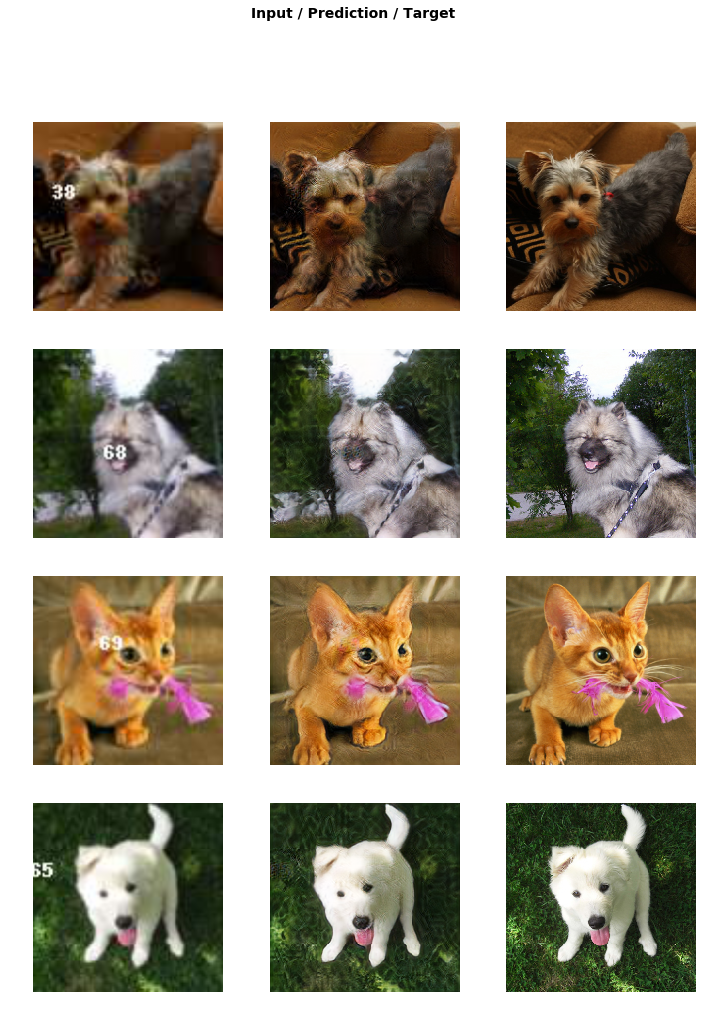

In [47]:
# Mostra um batch de resultados 
learn.show_results(rows=16)

In [48]:
learn.save('gan-1c')

## Conclusão

Com esse experimento, pudemos perceber um pouco do poder das GANs. É possível notar uma qualidade aceitável na área onde o texto aleatório foi retirado. 

Com relação à facilidade do _framework_, fast.ai, para se trabalhar com GANs, percebemos que necessita de algumas melhorias, dado que o experimento exigiu muito esforço e tempo de trabalho.

Como **trabalhos futuros**, seria interessante fazer o ajuste fino dos modelos generativo e crítico para trabalhar com imagens maiores (de melhor resolução) e testar outros valores de hiperparâmetros.